# CSE 5819 Assignment #6

**by: Aayushi Verma (uef24001)**

*due: Fri 10/28/24*

## Part 3 [Programming] (20 pts)

**In earlier HWs, you have already loaded the Seaborn Iris dataset. The dataset has four features:**

- **sepal_length**
- **sepal_width**
- **petal_length**
- **petal_width**

**and one target: **species**. It has three flower species: **setosa**, **versicolor**, and **virginica**. For this problem, please ignore **virginica**, meaning drop those data labeled with virginica.**

**Use sklearn's stratification partition to partition the Iris data into 70% for training and 30% for testing. Then use the sklearn function `sklearn.svm.SVC` to create a Support Vector Classifier that separates iris species between setosa and versicolor (please use C=1).**


In [1]:
# importing packages
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

First we load the dataset using the Seaborn library. 

**Note to TA:** I was having issues loading the dataset from Seaborn (ssl certificate error) so instead downloaded a local csv of the dataset. For the submission of this assignment on Google Colab, I will comment out my code which uses the local download of the datatset and keep the original line of code, and hope that it works on your end.

In [2]:
# # downloading the dataset from the Seaborn library
# iris = sns.load_dataset('iris')

# # dropping 'virginica' data
# iris = iris.drop(iris[iris['species'] == 'virginica'].index)

In [3]:
# loading the iris dataset from my locally-downloaded version
iris = pd.read_csv('iris.csv')
# renaming the columns to match the Seaborn version
iris.rename(columns={
    'SepalLengthCm': 'sepal_length',
    'SepalWidthCm': 'sepal_width',
    'PetalLengthCm': 'petal_length',
    'PetalWidthCm': 'petal_width',
    'Species': 'species'
}, inplace=True)

# dropping the Id column since Seaborn version doesn't have it
iris.drop(columns=['Id'], inplace=True)

# dropping 'virginica' data
iris = iris.drop(iris[iris['species'] == 'Iris-virginica'].index)

# Mapping the species to binary values
# 1 for 'Iris-setosa' and 0 for 'Iris-versicolor'
iris['target'] = (iris['species'] == 'Iris-setosa').astype(int)

In [4]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,target
0,5.1,3.5,1.4,0.2,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,1
2,4.7,3.2,1.3,0.2,Iris-setosa,1
3,4.6,3.1,1.5,0.2,Iris-setosa,1
4,5.0,3.6,1.4,0.2,Iris-setosa,1


Now that we have converted the Iris dataset into a numerical dataset, we can proceed by making `X` and `y` subsets of the data.

In [5]:
X = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
X

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
95,5.7,3.0,4.2,1.2
96,5.7,2.9,4.2,1.3
97,6.2,2.9,4.3,1.3
98,5.1,2.5,3.0,1.1


In [6]:
y = iris['target']
y

0     1
1     1
2     1
3     1
4     1
     ..
95    0
96    0
97    0
98    0
99    0
Name: target, Length: 100, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [8]:
# instantiating the SVM model and fitting the training data
svm = SVC(C=1, probability=True)  # Set probability=True to get probability estimates
svm.fit(X_train, y_train)

SVC(C=1, probability=True)

In [9]:
# Get probabilities for the positive class
class_probs = svm.predict_proba(X_test)[:, 1]  

In [10]:
# using test data to make predictions
y_pred = svm.predict(X_test)

# getting the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification Accuracy: {accuracy:.2f}')

Classification Accuracy: 1.00


### (1) [5 pts] 
**Please draw a ROC curve to represent the performance of your SVC.**

In HW#5, I wrote code to get TPR and FPR lists for the ROC curve, and plotting the results. Here's the code:

In [11]:
def calculate_roc_curve(class_probs, true_labels):
    # Step 1: Create a dataframe from class probabilities and true labels
    df = pd.DataFrame({'class_prob': class_probs, 'true_label': true_labels})
    
    # Step 2: Sort by class probabilities in ascending order
    df = df.sort_values(by='class_prob')
    
    # Initialize variables for ROC
    thresholds = sorted(df['class_prob'].unique())
    tpr_list = []  # True Positive Rate (TPR)
    fpr_list = []  # False Positive Rate (FPR)

    for threshold in thresholds:
        TP = FP = TN = FN = 0
        current_threshold = threshold
        
        # Step 3: Iterate over the probabilities and calculate TP, FP, TN, FN
        for _, row in df.iterrows():
            if row['class_prob'] >= current_threshold:
                if row['true_label'] == 1:
                    TP += 1
                else:
                    FP += 1
            else:
                if row['true_label'] == 1:
                    FN += 1
                else:
                    TN += 1
        
        # Step 4: Calculate TPR and FPR
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # True Positive Rate
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
        
        tpr_list.append(TPR)
        fpr_list.append(FPR)

    # Return TPR and FPR lists for plotting the ROC curve
    return fpr_list, tpr_list

def plot_roc_curve(fpr_list, tpr_list, class_label):
    # Step 1: Create the plot
    plt.figure(figsize=(8, 6))
    
    # Step 2: Plot FPR against TPR
    plt.plot(fpr_list, tpr_list, color='blue', marker='o', linestyle='-', label='ROC Curve')
    
    # Step 3: Plot the diagonal line representing random guess
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    
    # Step 4: Set labels and title
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {class_label}')
    plt.legend(loc='lower right')
    
    # Step 5: Show the plot
    plt.grid(True)
    plt.show()

Therefore let's now calculate the ROC curve and plotting it.

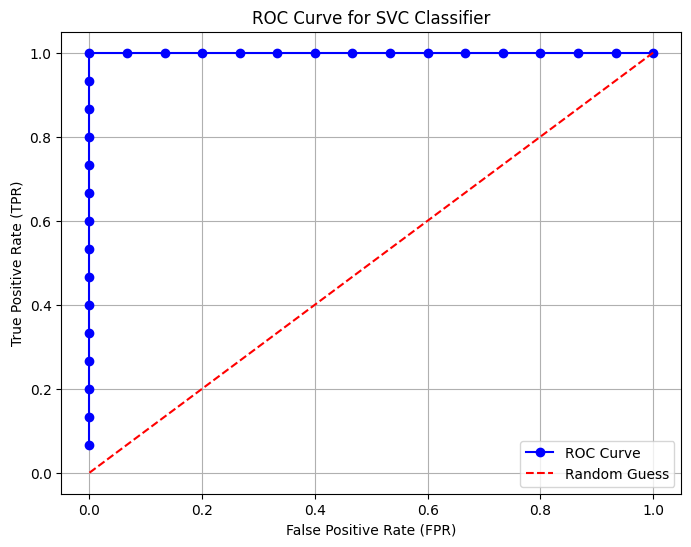

In [12]:
fpr_list, tpr_list = calculate_roc_curve(class_probs, y_test)

plot_roc_curve(fpr_list, tpr_list, class_label='SVC Classifier')

### (2) [5 pts] 
Remember in HW4, you have already created a logistic regression classifier. Please draw a ROC curve for that classifier on the same plot, and compare the two classifiers.


In [13]:
# instantiating the LogReg model and fitting the training data
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [14]:
# Get probabilities for the positive class
log_reg_class_probs = log_reg.predict_proba(X_test)[:, 1]  

In [15]:
# using test data to make predictions
y_pred = log_reg.predict(X_test)

In [16]:
# getting the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification Accuracy: {accuracy:.2f}')

Classification Accuracy: 1.00


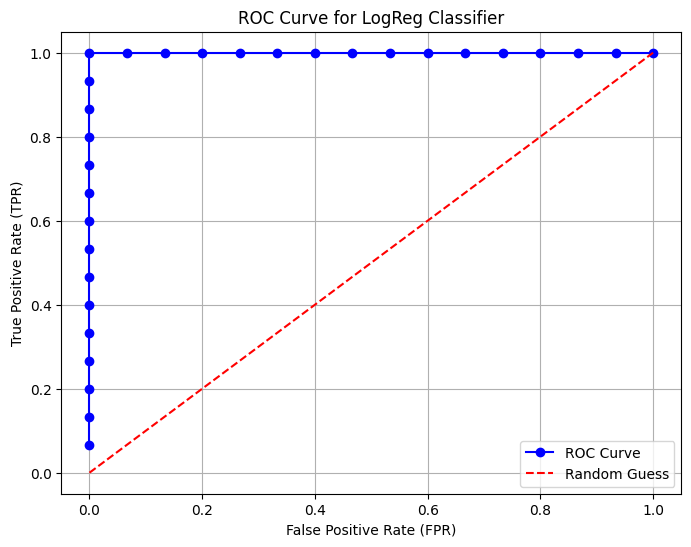

In [17]:
fpr_list, tpr_list = calculate_roc_curve(log_reg_class_probs, y_test)

plot_roc_curve(fpr_list, tpr_list, class_label='LogReg Classifier')

We note that the ROC curves for both SVM and LogReg are perfectly ideal, i.e. they are classifying TP correctly.

### (3) [10 pts] 
Using your training data, tune the SVC’s hyperparameter C. Note that to avoid cheating on the final test performance, you should have another random split within your training data or use cross-validation on your training data to compare the performance of SVC when choosing different values of C. Once you observe the best cross-validation performance, fix C to that optimal value and retrain your SVC using the full training data. Then apply that final classifier to your test data. Report the classification accuracy of the final classifier on the test data. Print two columns for the test dataset where the first one is the ground truth labels and the second one is your model’s predictions.


In [18]:
# Define the SVC model
svm_model = SVC()

# Define a range of C values to test
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Perform cross-validation on the training data
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best C value
best_C = grid_search.best_params_['C']
print(f'Best C value: {best_C}')

# Retrain the SVC with the best C value on the entire training set
final_svm_model = SVC(C=best_C)
final_svm_model.fit(X_train, y_train)

# Apply the final classifier to the test data
y_pred = final_svm_model.predict(X_test)

# Calculate the classification accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification Accuracy on test data: {accuracy:.2f}')

# Print the ground truth labels and model predictions
print("\nGround truth vs Predictions:")
for true_label, pred_label in zip(y_test, y_pred):
    print(f"{true_label}    {pred_label}")

Best C value: 0.01
Classification Accuracy on test data: 1.00

Ground truth vs Predictions:
0    0
0    0
1    1
0    0
0    0
1    1
1    1
1    1
1    1
0    0
1    1
1    1
0    0
0    0
1    1
1    1
0    0
0    0
1    1
0    0
0    0
0    0
1    1
1    1
0    0
0    0
1    1
1    1
1    1
0    0
